# Import Dependencies

In [2]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

In [ ]:
# For bitcoin only

In [3]:
with open("./data/btc.pickle", 'rb') as f:
    btc = pickle.load(f)

In [5]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


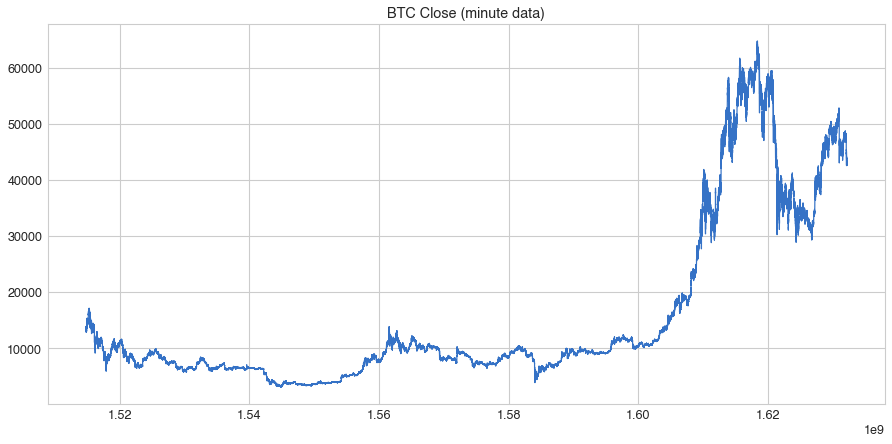

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(btc.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

# Forecast Quality Metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [8]:
# Importing metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [10]:
def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(btc.Close, 15) # prediction for the last observed day (past 24 hours)

42700.40728489211

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [117]:
# Before moving forward, let's create a shorter version of our dataset so it's easily visible
btc_mini = btc.copy()
btc_mini = btc_mini.iloc[-700:,:]

In [118]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
        df - dataframe with timeseries
        column_name - name of column to analyze (choose 1 at a time)
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """

    rolling_mean = btc_mini.Target.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "red", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(
            series[window:], rolling_mean[window:]
        )
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(b=True)

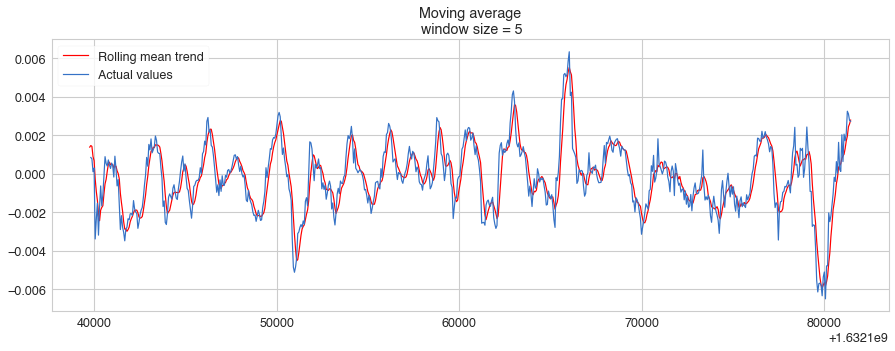

In [119]:
# 5-step trend
plotMovingAverage(btc_mini.Target, window=5)

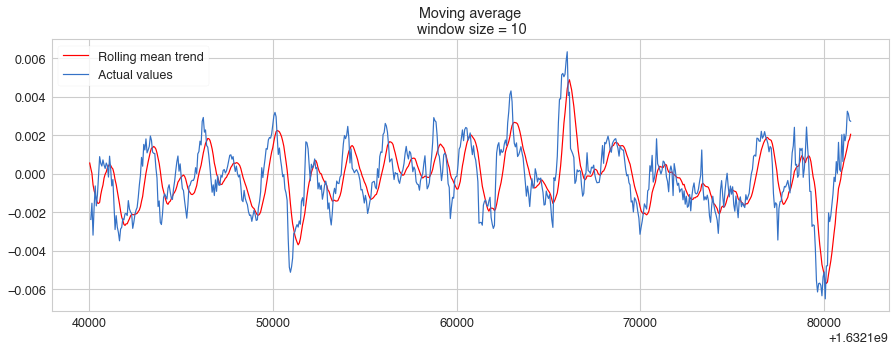

In [120]:
# 10-step trend
plotMovingAverage(btc_mini.Target, window=10) 

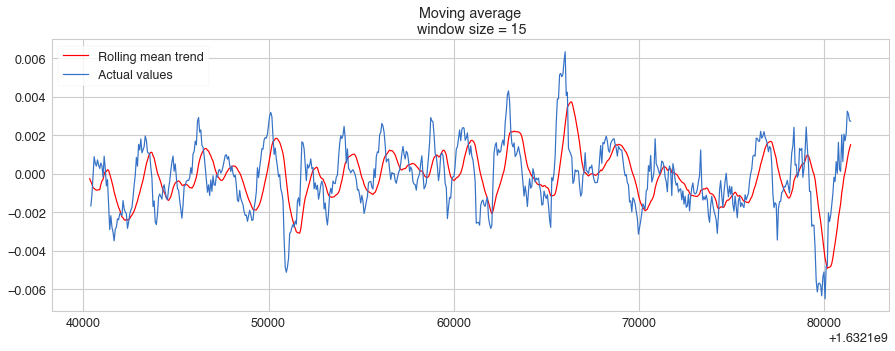

In [121]:
# 15-step trend
plotMovingAverage(btc_mini.Target, window=15) 

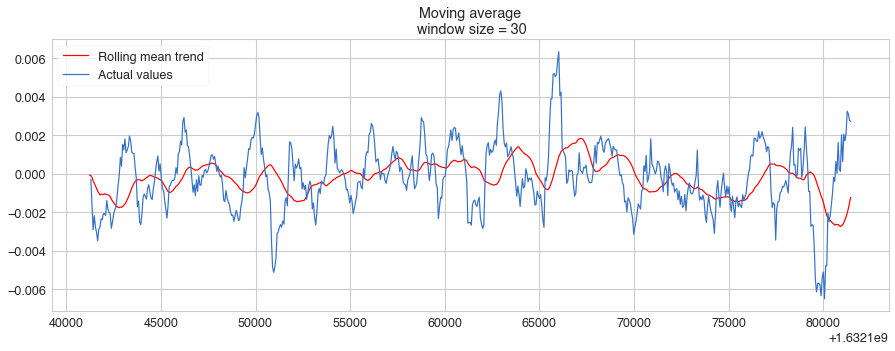

In [122]:
# 30-step trend
plotMovingAverage(btc_mini.Target, window=30)

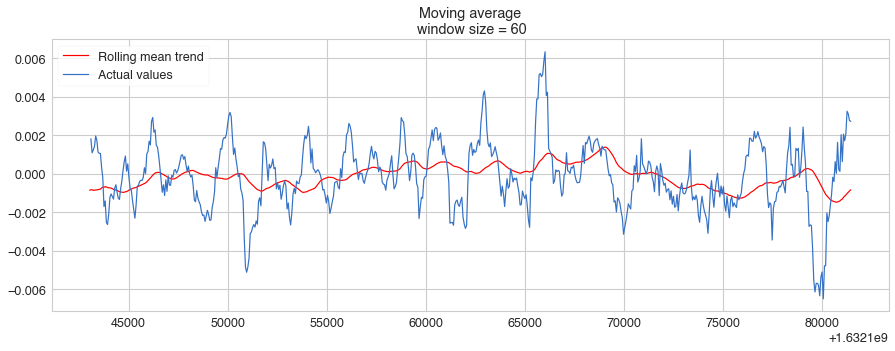

In [123]:
# 60-step trend
plotMovingAverage(btc_mini.Target, window=60)

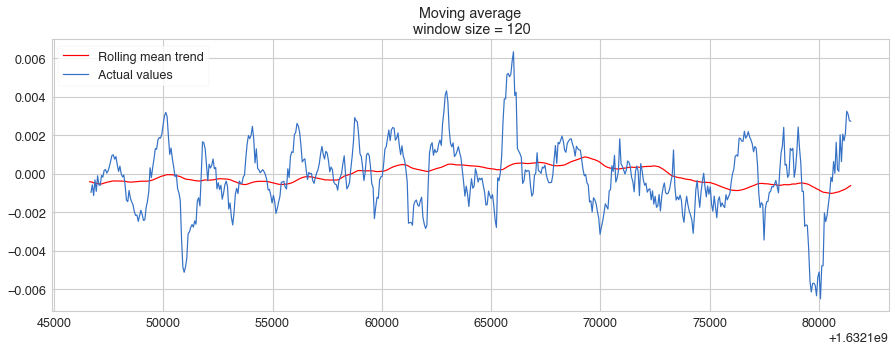

In [124]:
# 120-step trend
plotMovingAverage(btc_mini.Target, window=120)

Now, let's create a simple anomaly detection system with the help of moving average. 

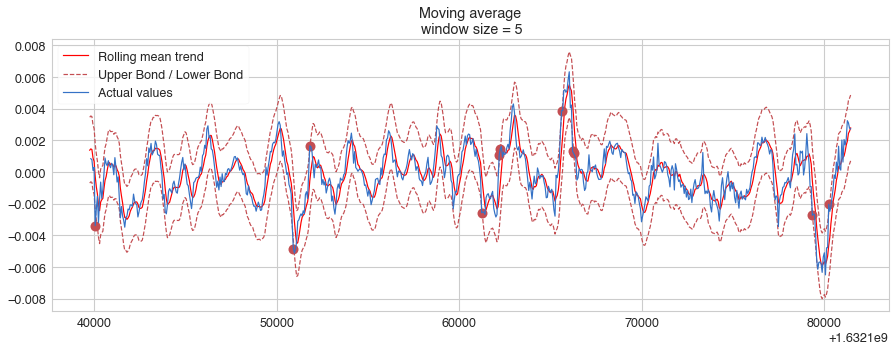

In [125]:
plotMovingAverage(btc_mini.Target, window=5, plot_intervals=True, plot_anomalies=True)

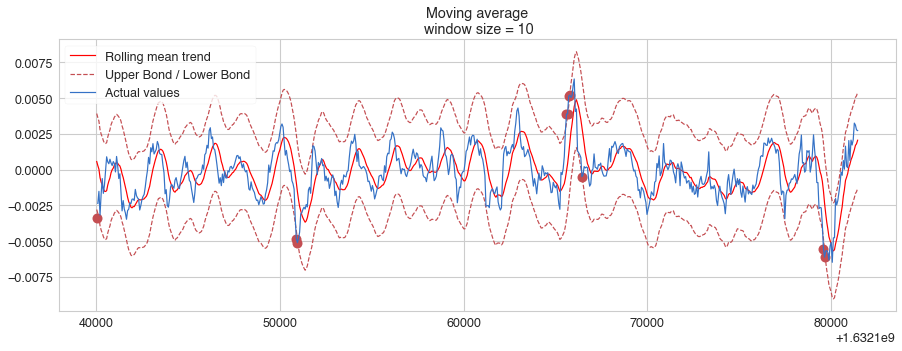

In [126]:
plotMovingAverage(btc_mini.Target, window=10, plot_intervals=True, plot_anomalies=True)

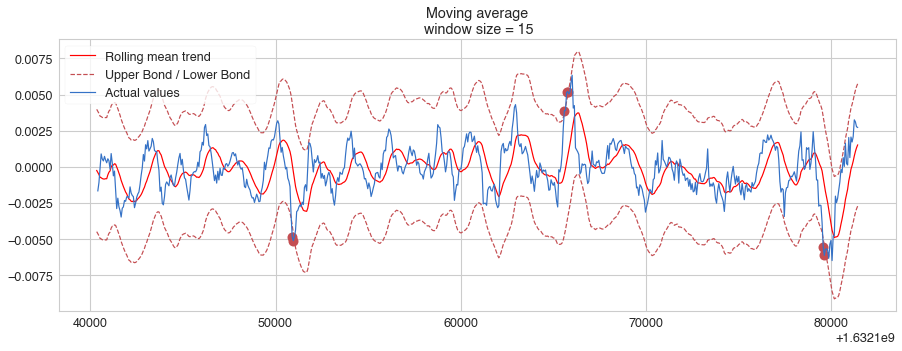

In [127]:
plotMovingAverage(btc_mini.Target, window=15, plot_intervals=True, plot_anomalies=True)

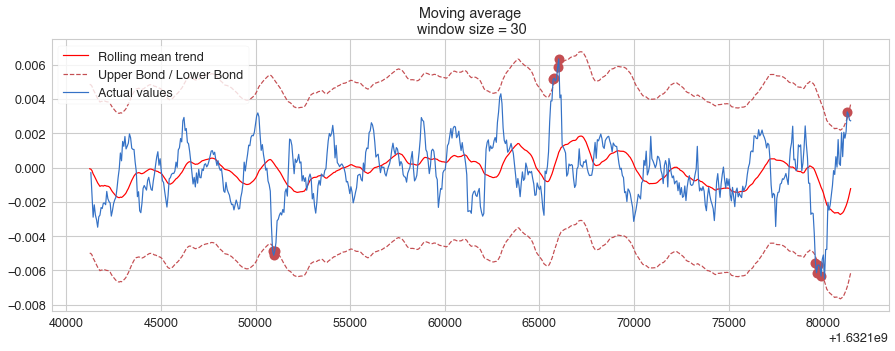

In [128]:
plotMovingAverage(btc_mini.Target, window=30, plot_intervals=True, plot_anomalies=True)

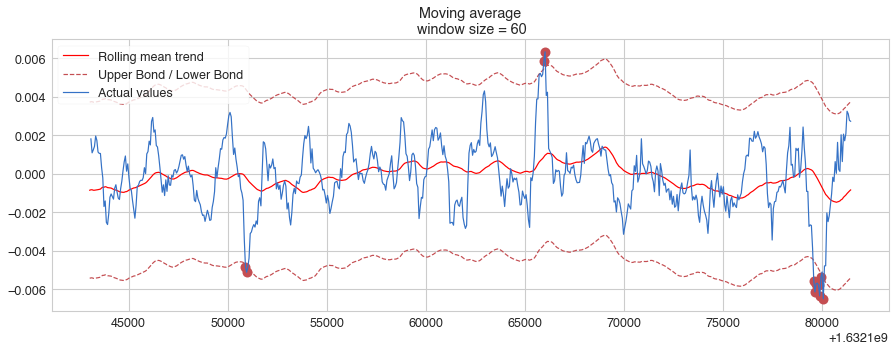

In [129]:
plotMovingAverage(btc_mini.Target, window=60, plot_intervals=True, plot_anomalies=True)

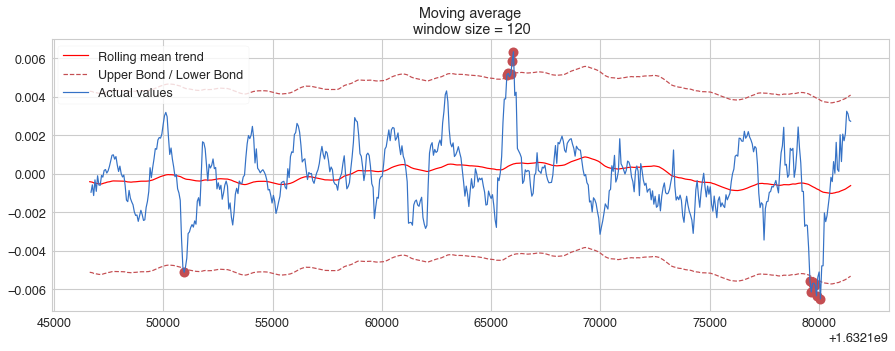

In [130]:
plotMovingAverage(btc_mini.Target, window=120, plot_intervals=True, plot_anomalies=True)